<a href="https://colab.research.google.com/github/ffedox/nlp/blob/main/Regression_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression with BERT


# 1. Setup

## 1.1. Enabling the GPU on Colab

Checking if there is a GPU available and setting the `device` to "cuda" if there is one.

In [ ]:
import torch

# If there's a GPU avaiable, tell PyTorch to use the GPU,
# otherwise, using the CPU instead.
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('Found GPU:', torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print('CPU will be used because no GPU available.')

Found GPU: Tesla T4


## 1.2. Installing the Hugging Face Library

Installing the PyTorch interface for BERT by Hugging Face.

In [ ]:
!pip install transformers --quiet

# 2. Loading the Grey's Anatomy Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
data = pd.read_excel('/content/drive/MyDrive/DAR/greys_anatomy_data_train_val_test.xlsx', index_col=0)

In [ ]:
# Get train, val and test indexes.
train_indexes = data.index[data['data_type'] == 'train'].tolist()
val_indexes = data.index[data['data_type'] == 'val'].tolist()
test_indexes = data.index[data['data_type'] == 'test'].tolist()

# Get the lists of sentences and their labels.
sentences = data.subtitle_text.values
labels = data[['pp', 'sp', 'mc']].values

# 3. Tokenization & Input Formatting

## 3.1. BERT Tokenizer

Using the `transformers` library to load the `BertTokenizer`.

In [ ]:
from transformers import BertTokenizer, BertModel, AdamW

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

# Uncased means that the text has been lower cased before Word Piece
# tokenization, e.g., John Smith becomes john smith. The Uncased model also
# strips out any accent markers.
bert_pretrained_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_pretrained_model_name)#, do_lower_case=True)

Loading BERT tokenizer...


## 3.2. Tokenize Dataset

Perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [ ]:
def get_max_sentence_length(sentences):

  max_len = 0

  # For every sentence...
  for sent in sentences:

      # Tokenize the text and add '[CLS]' and '[SEP]' tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  return max_len

max_sentence_length = get_max_sentence_length(sentences)

Using the `tokenizer.batch_encode_plus` method to encode (i.e., convert into numerical representations) the two datasets: the training dataset and the validation dataset. The following parameters are used:


*   `add_special_tokens=True` adds special tokens such as [CLS] and [SEP] to the beginning and end of each sentence.
*   `return_attention_mask=True` returns a tensor indicating the attention mask, which is used to tell the model where the sentence ends.
*   `max_length` sets the maximum length for the encoded sentences, with longer sentences truncated and shorter sentences padded to this length.
*   `truncation=True` explicitly truncates sentences to the max_length.
*   `padding='max_length'` specifies that padding should be added to sentences to reach the max_length.
*   `return_tensors='pt'` specifies that PyTorch tensors should be returned.


In [ ]:
# Encode training dataset using the tokenizer.
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type == 'train'].subtitle_text.values,
    add_special_tokens=True,
    return_attention_mask=True,  # So we know when a sentence is finished.
    max_length=max_sentence_length,
    truncation=True,            # Explicitely truncate sentences to max length.
    padding='max_length',
    return_tensors='pt'
)

# Encode validation dataset using the tokenizer.
encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type == 'val'].subtitle_text.values,
    add_special_tokens=True,
    return_attention_mask=True,  
    max_length=max_sentence_length,
    truncation=True, 
    padding='max_length',
    return_tensors='pt'
)

Extracting `input_ids`, `attention_masks`, and `labels` from each dataset.

`input_ids` are numerical representations of a text sequence. They are usually obtained by encoding the words of a text sequence using a pre-trained tokenizer. Each word is represented by a unique numerical identifier (token), and the sequence of tokens represents the text sequence.

`attention_masks` are binary arrays that indicate which elements of the input_ids are real tokens and which are padding. The attention mask is used to distinguish real tokens from padding elements.

In [ ]:
from torch.utils.data import TensorDataset

# Extract IDs, attention masks and labels from training dataset.
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type == 'train'][['pp', 'sp', 'mc']].values, dtype=torch.float32)
labels_train

# Extract IDs, attention masks and labels from validation dataset.
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type == 'val'][['pp', 'sp', 'mc']].values, dtype=torch.float32)
     
# Create train and validation dataset from extracted features.
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
print("Train dataset length: {}\nValidation dataset length: {}".format(len(dataset_train), len(dataset_val)))

Train dataset length: 55567
Validation dataset length: 11907


Creating an iterator for the dataset using the torch `DataLoader` class. This helps save on memory during training because, unlike a for loop, an iterator does not load into memory the entire dataset.

In [ ]:
from torch.utils.data import DataLoader

# The DataLoader needs to know the batch size for training, so it is specified  
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Creating the DataLoaders for our training and validation sets.
# Taking training samples in random order. 
train_dataloader = DataLoader(
    dataset_train,  # The training samples.
    shuffle = True, # Select batches randomly.
    batch_size = batch_size)  # Train with this batch size.

# For validation the order doesn't matter, so they are processed sequentially.
val_dataloader = DataLoader(
    dataset_val,  # The validation samples.
    shuffle = False,  # Default: Pull out batches sequentially.
    batch_size = batch_size)  # Evaluate with this batch size.

# 4. Training the Model

## 4.1. Creating a Bert model with a regression layer on top

Defining a custom PyTorch module for regression. It combines a pre-trained BERT model with a linear layer to predict the outputs.

In the `init` method, the code instantiates the pre-trained BERT model using the `bert_pretrained_model_name` as a parameter. Then, a linear layer with `output_size` output units is added on top of the BERT model to perform the sequence regression. 

The `forward` method is called when the model is used to make predictions on a batch of input data.

In the `forward` method, the BERT model is called with the `input_sentence` and `input_mask` arguments to produce a hidden representation of the input sentence, which is stored in the `last_hidden_states` variable. The `last_hidden_states` tensor is then passed through a linear layer, represented by the `self.out` variable, to produce the predictions. Finally, the `torch.sigmoid` function is applied to the predictions to constrain the output values within the [0,1] range.

In summary, the `forward` method of the `BertForSequenceRegression` class takes an input sentence and its corresponding attention mask, passes the input through a pre-trained BERT model, and outputs a prediction for the target variable, which has been constrained within the [0,1] range using the sigmoid function.

In [ ]:
import torch.nn as nn

# Bert Model transformer with a sequence regression head on top (a linear
# layer on top of the pooled output).
class BertForSequenceRegression(nn.Module):
  def __init__(self, bert_pretrained_model_name, output_size):
    super(BertForSequenceRegression, self).__init__()
    self.bert = BertModel.from_pretrained(bert_pretrained_model_name,
                                          output_attentions = False,
                                          output_hidden_states = False)
    self.out = nn.Linear(self.bert.config.hidden_size, output_size)

  def forward(self, input_sentence, input_mask):
    last_hidden_states = self.bert(input_sentence, attention_mask=input_mask)[1]
    output = self.out(last_hidden_states)
    output = torch.sigmoid(output) # Using a sigmoid in the output layer
    return output

model = BertForSequenceRegression(bert_pretrained_model_name, output_size=3)

# Tell pytorch to run this model on the GPU
model.to(device)

## 4.2. Training Loop

Helper function for formatting elapsed times as hh:mm:ss.

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Defining the training loop for the model. The model is trained on the provided training dataset for 2 epochs. The Adam optimizer is used to update the model's parameters based on the loss, which is calculated using the mean squared error loss. The training loop also measures and reports the average training loss and the time it took to complete each epoch. After each training epoch, the code performs a validation step on a validation dataset, calculating the loss on the validation set and storing the results in `training_stats`.

In [ ]:
import torch.optim as optim

# Optimizer (lr options: 2e-5, 3e-5, 5e-5)
optimizer = optim.Adam(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 2

# Loss function
criterion = torch.nn.MSELoss() 

# Storing statistics such as training loss and timings
training_stats = []

# Measuring the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
    
  # Perform one full pass over the training set.
  
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode.
  # Dropout layers behave differently during training vs. eval mode.
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using the 
    # `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # zero gradients
    optimizer.zero_grad()
    model.zero_grad()  

    # Perform a forward pass (evaluate the model on this training batch).
    output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output.view(-1), b_labels.view(-1))
      
    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))
  
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure the performance on
  # the validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in val_dataloader:

    # Unpack this training batch from the dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      
      # Perform a forward pass
      output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output.view(-1), b_labels.view(-1))

    # Accumulate the development loss.
    total_eval_loss += loss.item()

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_dataloader)

  # Measure how long the development run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
          'Valid. Loss': avg_val_loss,
          'Validation Time': validation_time
      })
  
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,737.    Elapsed: 0:00:08.
  Batch    80  of  1,737.    Elapsed: 0:00:16.
  Batch   120  of  1,737.    Elapsed: 0:00:24.
  Batch   160  of  1,737.    Elapsed: 0:00:33.
  Batch   200  of  1,737.    Elapsed: 0:00:41.
  Batch   240  of  1,737.    Elapsed: 0:00:49.
  Batch   280  of  1,737.    Elapsed: 0:00:57.
  Batch   320  of  1,737.    Elapsed: 0:01:05.
  Batch   360  of  1,737.    Elapsed: 0:01:13.
  Batch   400  of  1,737.    Elapsed: 0:01:21.
  Batch   440  of  1,737.    Elapsed: 0:01:29.
  Batch   480  of  1,737.    Elapsed: 0:01:37.
  Batch   520  of  1,737.    Elapsed: 0:01:46.
  Batch   560  of  1,737.    Elapsed: 0:01:54.
  Batch   600  of  1,737.    Elapsed: 0:02:02.
  Batch   640  of  1,737.    Elapsed: 0:02:10.
  Batch   680  of  1,737.    Elapsed: 0:02:18.
  Batch   720  of  1,737.    Elapsed: 0:02:26.
  Batch   760  of  1,737.    Elapsed: 0:02:35.
  Batch   800  of  1,737.    Elapsed: 0:02:43.
  Batch   840  of

In [ ]:
# Display floats with three decimal places.
pd.set_option('precision', 4)

# Create a DataFrame with the training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Training Time,Valid. Loss,Validation Time
epoch,,,,
1,0.1470,0:05:53,0.1435,0:00:23
2,0.1336,0:05:53,0.1433,0:00:23


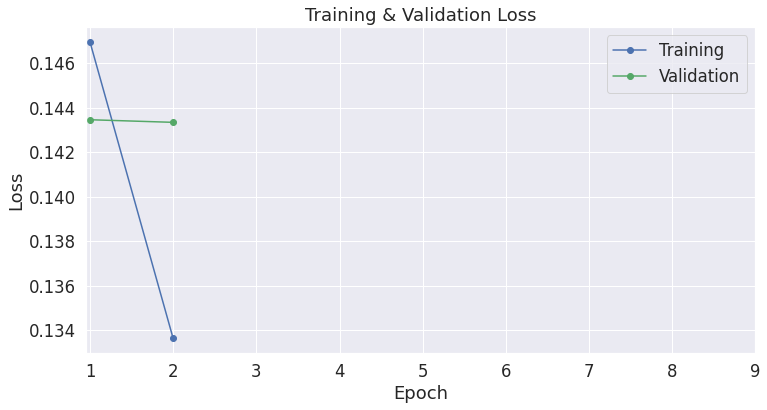

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.show()

# 5. Performance On Test Set

In [ ]:
# Encode test dataset using the tokenizer.
encoded_data_test = tokenizer.batch_encode_plus(
    data[data.data_type == 'test'].subtitle_text.values,
    add_special_tokens=True,
    return_attention_mask=True,  
    max_length=max_sentence_length,
    truncation=True,
    padding='max_length',
    return_tensors='pt'
)

In [ ]:
# Extract IDs, attention masks and labels from testing dataset.
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(data[data.data_type == 'test'][['pp', 'sp', 'mc']].values, dtype=torch.float32)

dataset_test = TensorDataset(input_ids_test, attention_masks_test)
test_dataloader = DataLoader(dataset_test)
print("Test dataset length: {}".format(len(dataset_test)))

Test dataset length: 11908


Defining a function `predict` that takes as input a test dataloader (`test_dataloader`) and returns a list of predictions. The function loops over the rows of the test dataloader and performs the following steps:

1.   For each row in the test dataloader, it converts each element of the row to a PyTorch tensor and transfers it to the specified device.
2.   It defines a dictionary called `inputs` that holds the converted tensors as inputs to the model.
3.   It performs an evaluation of the model on the inputs using `model(**inputs)`
4. The output of the model is a tensor `outputs[0]`. The outputs are detached from the computation history of the model and converted to a numpy array.
5. It appends the outputs to the list `predictions`.

The function is called on the test dataloader and the target values from the test set are collected to compare them with the predictions.

In [ ]:
def predict(test_dataloader):

    predictions = []

    for row in test_dataloader:
      row = tuple(r.to(device) for r in row)
      inputs = {'input_sentence': row[0],
        'input_mask': row[1]
        }

      with torch.no_grad():
          outputs = model(**inputs)

      outputs = outputs[0]
      outputs = outputs.detach().cpu().numpy()
      predictions.append(outputs)

    return predictions

# Predict on the test set
predictions = predict(test_dataloader)

# Collect target values from test set
true = data[data.data_type=='test'][['pp', 'sp', 'mc']].values

In [ ]:
from sklearn.metrics import mean_absolute_error

print('MAE (ALL) ', mean_absolute_error(true, predictions), ' \n')
print('MAE (PP): ', list(mean_absolute_error(true, predictions, multioutput='raw_values'))[0])
print('MAE (SP): ', list(mean_absolute_error(true, predictions, multioutput='raw_values'))[1])
print('MAE (MC): ', list(mean_absolute_error(true, predictions, multioutput='raw_values'))[2])

MAE (ALL)  0.28447874390506517  

MAE (PP):  0.19081222371789794
MAE (SP):  0.3517186488272645
MAE (MC):  0.31090535917003304


In [ ]:
from sklearn.metrics import mean_squared_error

print('RMSE (ALL) ', mean_squared_error(true, predictions), ' \n')
print('RMSE (PP): ', list(mean_squared_error(true, predictions, squared=False, multioutput='raw_values'))[0])
print('RMSE (SP): ', list(mean_squared_error(true, predictions, squared=False, multioutput='raw_values'))[1])
print('RMSE (MC): ', list(mean_squared_error(true, predictions, squared=False, multioutput='raw_values'))[2])

RMSE (ALL)  0.1947259128134251  

RMSE (PP):  0.3798935650353424
RMSE (SP):  0.47378505418077
RMSE (MC):  0.46409733905716183


In [ ]:
from sklearn.metrics import r2_score

print('R2 (ALL) ', r2_score(true, predictions), ' \n')
print('R2 (PP): ', list(r2_score(true, predictions, multioutput='raw_values'))[0])
print('R2 (SP): ', list(r2_score(true, predictions, multioutput='raw_values'))[1])
print('R2 (MC): ', list(r2_score(true, predictions, multioutput='raw_values'))[2])

R2 (ALL)  0.08185937970920376  

R2 (PP):  0.05261516561868784
R2 (SP):  0.1152448402277021
R2 (MC):  0.07771813328122135
